![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# **Taller No. 8 - ISIS4825**
## **Proceso de Aprendizaje Automático e Introducción a la Clasificación**
## **Contenido**
1. [**Objetivos**](#id1)
2. [**Problema**](#id2)
3. [**Importando las librerías necesarias para el laboratorio**](#id3)
4. [**Visualización y Análisis Exploratorio**](#id4)
5. [**Preparación de los Datos**](#id5)
6. [**Modelamiento**](#id6)
7. [**Predicción**](#id7)
8. [**Validación**](#id8)
9. [**Trabajo Asíncrono**](#id9)

## **Objetivos**<a name="id1"></a>
- Familiarizarse con las librerías de Scikit-Learn y con el algoritmo de KNN
- Resolver un problema de clasificación multiclase y tomar métricas de desempeño sobre este

## **Problema**<a name="id2"></a>
- En una tienda de ropa buscan crear un algoritmo de clasificación que asigne una etiqueta a 10 tipos de prendas distintas. Desde ropa hasta accesorios.

## **Importando las librerías necesarias para el laboratorio**<a name="id3"></a>

In [56]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (train_test_split, ShuffleSplit, 
                                     cross_val_score, GridSearchCV)
from sklearn.metrics import (precision_score, recall_score, confusion_matrix, 
                             accuracy_score, f1_score, roc_curve, 
                             precision_recall_curve)

import utils.general as gen

from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

## **Visualización y Análisis Exploratorio**<a name="id4"></a>
- Vamos a hacer uso del Dataset `Fashion-MNIST` que consta de 10 clases:
    0. T-Shirt/Top
    1. Trouser
    2. Pullover
    3. Dress
    4. Coat
    5. Sandal
    6. Shirt 
    7. Sneaker
    8. Bag
    9. Ankle Boot
- De igual forma, el dataset tiene 70.000 imágenes en escala de rises con resolución 28x28. Sin embargo, las imágenes ya se encuentran aplanadas con tamaño ed vector 784.

In [4]:
fashion_mnist = datasets.fetch_openml("Fashion-MNIST")

In [5]:
data, target = fashion_mnist.data, fashion_mnist.target

In [6]:
data.shape, target.shape

((70000, 784), (70000,))

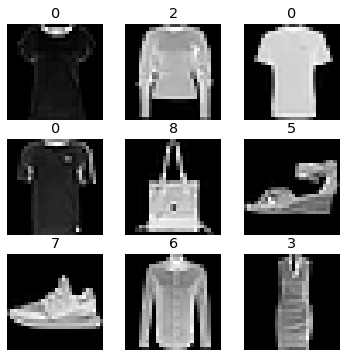

In [7]:
random_sample = np.random.choice(np.arange(len(data)), 9)
gen.visualize_subplot(
    data[random_sample].reshape(-1, 28, 28),
    target[random_sample],  (3, 3), (6, 6)
)

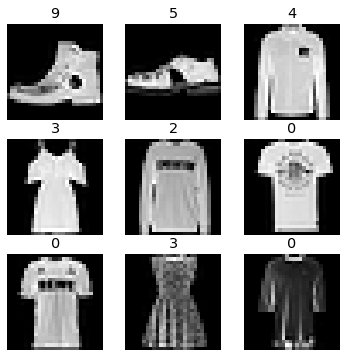

In [8]:
random_sample = np.random.choice(np.arange(len(data)), 9)
gen.visualize_subplot(
    data[random_sample].reshape(-1, 28, 28),
    target[random_sample],  (3, 3), (6, 6)
)

In [9]:
target_classes = ["T-Shirt/Top", "Trouser", "Pullover", "Dress", 
                  "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

In [10]:
target_distribution = pd.Series(target).value_counts().sort_index()
target_distribution.index = target_classes

In [11]:
target_distribution

T-Shirt/Top    7000
Trouser        7000
Pullover       7000
Dress          7000
Coat           7000
Sandal         7000
Shirt          7000
Sneaker        7000
Bag            7000
Ankle Boot     7000
dtype: int64

## **Preparación de los Datos**<a name="id5"></a>
- Dado que estamos trabajando con modelos de Machine Learning superficial, vamos a necesitar que todas nuestras imágenes sean convertidas a vectores, si es que aún no lo son.

### **Tratamiento de Imágenes**
- En este caso, nuestras imágenes son vectores, sin embargo vamos a ver cómo hacer su transformación vector-imagen e imagen-vector

In [12]:
sample_img = data[0].reshape(28, 28)
sample_target = target[0]

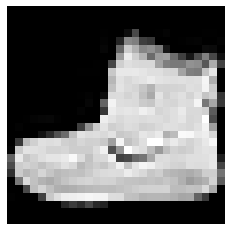

In [13]:
gen.imshow(sample_img, color=False)

In [14]:
sample_img.shape

(28, 28)

In [15]:
sample_img = sample_img.flatten()

In [16]:
sample_img.shape

(784,)

### **Train Set, Validation Set, Test Set**
- Generalmente, en el mundo del computer vision, se hace la siguiente partición de datasets:
    - Train Data:
        - Train Set
        - Validation Set
    - Test Data:
        - Test Set
- La partición de los datasets la podemos hacer de varias formas, pero en esta ocasión veremos la partición por índices y por contenido.

#### **Partición por Índice**
- Buscamos dividir nuestro dataset a partir de sus índices.

In [17]:
rnd_data = np.random.choice(np.arange(len(data)), 10000)
full_data = data.copy()
full_target = target.copy()
data = data[rnd_data]
target = target[rnd_data]

- Aquí usamos el `random_state` para definir una semilla de aleatoriedad para que los grupos generados se mantengan siempre.

In [18]:
ss_full_train_test = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1234)

In [19]:
for full_train_index, test_index in ss_full_train_test.split(data):
    pass

In [20]:
full_train_index

array([ 155, 3130, 5727, ..., 7948, 1064, 1750])

In [21]:
test_index

array([6899,  214, 5124, ..., 9211, 9399, 9295])

In [22]:
full_train_set, test_set = ((data[full_train_index], target[full_train_index]), 
                            (data[test_index], target[test_index]))

In [23]:
ss_train_val = ShuffleSplit(n_splits=10, test_size=0.2, random_state=5678)

In [24]:
for train_index, val_index in ss_train_val.split(full_train_set[0]):
    pass

In [25]:
train_set, val_set = ((full_train_set[0][train_index], full_train_set[1][train_index]), 
                      (full_train_set[0][val_index], full_train_set[1][val_index]))

In [26]:
X_train, y_train = train_set[0], train_set[1]
X_val, y_val = val_set[0], val_set[1]
X_test, y_test = test_set[0], test_set[1]

In [27]:
X_train.shape, y_train.shape

((6400, 784), (6400,))

In [28]:
X_val.shape, y_val.shape

((1600, 784), (1600,))

In [29]:
X_test.shape, y_test.shape

((2000, 784), (2000,))

- Generemos una muestra de imágenes por cada set generado.

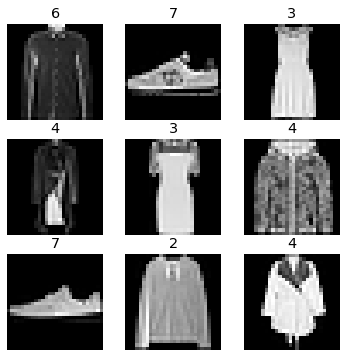

In [30]:
random_sample = np.random.choice(np.arange(len(X_train)), 9)
gen.visualize_subplot(
    X_train[random_sample].reshape(-1, 28, 28),
    y_train[random_sample],  (3, 3), (6, 6)
)

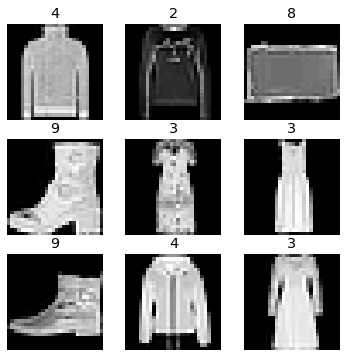

In [31]:
random_sample = np.random.choice(np.arange(len(X_val)), 9)
gen.visualize_subplot(
    X_val[random_sample].reshape(-1, 28, 28),
    y_val[random_sample],  (3, 3), (6, 6)
)

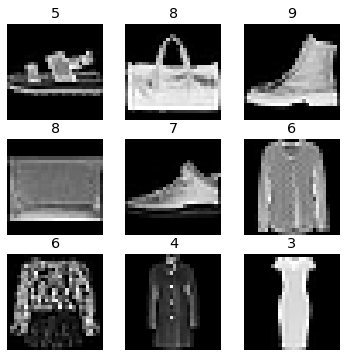

In [32]:
random_sample = np.random.choice(np.arange(len(X_test)), 9)
gen.visualize_subplot(
    X_test[random_sample].reshape(-1, 28, 28),
    y_test[random_sample],  (3, 3), (6, 6)
)

#### **Partición por Contenido**
- Aquí no buscamos partir nuestro dataset a partir de los índices que contiene, sino por el cuerpo de la data.

In [33]:
full_X_train, X_test, full_y_train, y_test = train_test_split(data, target, 
                                                              test_size=0.2, 
                                                              random_state=1234)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(full_X_train, full_y_train, 
                                                  test_size=0.2, 
                                                  random_state=1234)

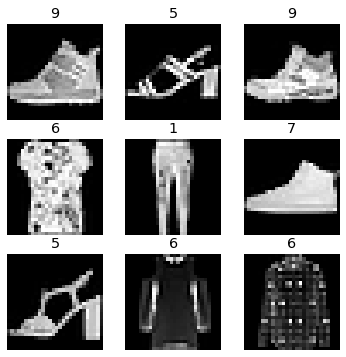

In [35]:
random_sample = np.random.choice(np.arange(len(X_train)), 9)
gen.visualize_subplot(
    X_train[random_sample].reshape(-1, 28, 28),
    y_train[random_sample],  (3, 3), (6, 6)
)

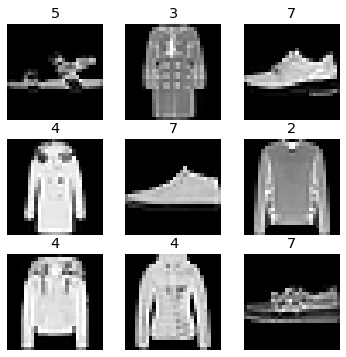

In [36]:
random_sample = np.random.choice(np.arange(len(X_val)), 9)
gen.visualize_subplot(
    X_val[random_sample].reshape(-1, 28, 28),
    y_val[random_sample],  (3, 3), (6, 6)
)

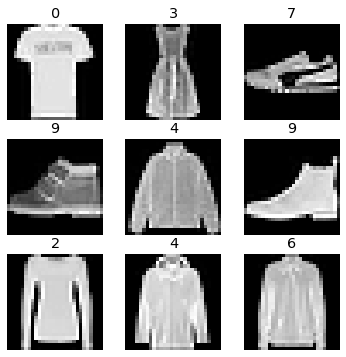

In [37]:
random_sample = np.random.choice(np.arange(len(X_test)), 9)
gen.visualize_subplot(
    X_test[random_sample].reshape(-1, 28, 28),
    y_test[random_sample],  (3, 3), (6, 6)
)

## **Modelamiento**<a name="id6"></a>
- A la hora de modelar los datos, buscamos un algoritmo que generalice la forma como los datos se comportan y con base a ello, pueda generar predicciones.

### **K-Nearest-Neighbors**
- En este caso, vamos a utilizar un algoritmo de modelado no lineal basado en vecindades o *neighborhoods*. Se trata de *K-Nearest Neighbors*.

![image](https://miro.medium.com/max/3544/1*4F-q86XFr2-EsaAcz0Zu5A.png)

> Tomado de [Towards Data Science](https://towardsdatascience.com/k-nearest-neighbor-python-2fccc47d2a55)

- Este espacio lo tomamos, generalmente, para buscar algoritmos que puedan ser usados para modelar, y una vez encontrados, exploramos los hiperparámetros que podamos usar para mejorar los resultados de nuestros algoritmos.

In [38]:
KNeighborsClassifier?

In [39]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

In [40]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

## **Predicción**<a name="id7"></a>
- En esta etapa nos concentramos en hacer nuestras predicciones y validarlas con el ojo.

In [41]:
random_sample = np.random.choice(np.arange(len(X_test)), 9)
y_pred = knn_clf.predict(X_test[random_sample])

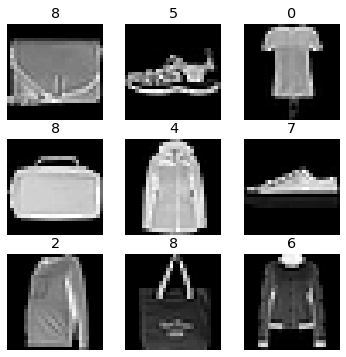

In [42]:
gen.visualize_subplot(
    X_test[random_sample].reshape(-1, 28, 28),
    y_pred, (3, 3), (6, 6)
)

## **Validación**<a name="id8"></a>
- En esta etapa de evaluación realizamos el proceso de toma de métricas. Por lo tanto, dado que estamos resolviendo un problema de clasificación, vamos a usar la matriz de confusión y las siguientes métricas globales:

- Precision: $\frac{TP}{TP + FP}$

- Cobertura: $\frac{TP}{TP + FN}$ (Recall, Sensitivity)

- Accuracy score: $\frac{TP + TN}{TP + TN + FP + FN}$

- F1 score: $\frac{TP}{TP + \frac{FN + FP}{2}}$ (Harmonic Mean)

In [43]:
y_pred = knn_clf.predict(X_test)

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred)

In [45]:
pd.DataFrame(conf_matrix)

,0,1,2,3,4,5,6,7,8,9
0,184,0,3,4,0,0,13,0,1,0
1,1,163,1,5,1,0,2,0,0,0
2,4,0,155,3,20,0,16,0,0,0
3,14,0,3,177,16,0,3,0,0,0
4,0,0,41,4,146,0,21,0,0,0
5,0,0,0,0,0,150,1,26,0,25
6,43,0,28,1,14,0,98,0,2,0
7,0,0,0,0,0,0,0,169,0,13
8,0,0,6,5,3,0,3,1,197,1
9,0,0,1,1,0,0,0,9,0,202


- En esta matriz de confusión podemos ver claramente que las diagonales sobresalen, es decir, hubo un gran número de predicciones correctas.

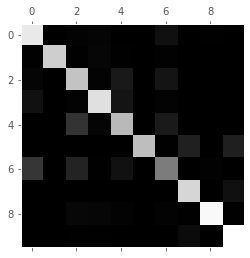

In [46]:
plt.matshow(conf_matrix, cmap="gray")
plt.grid(0)
plt.show()

In [47]:
np.trace(conf_matrix)

1641

In [48]:
norm_conf_mat = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)

- Aquí vemos que, aunque nuestro algoritmo clasificó correctamente alrededor del 80% de nuestro dataset, siempre las clasificaciones erróneas fueron bastantes.

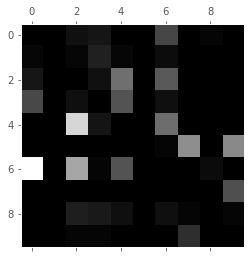

In [49]:
plt.matshow(norm_conf_mat, cmap="gray")
plt.grid(0)
plt.show()

In [50]:
accuracy_score(y_test, y_pred)

0.8205

In [51]:
precision_score(y_test, y_pred, average="weighted")

0.8289899843577427

In [52]:
recall_score(y_test, y_pred, average="weighted")

0.8205

In [53]:
f1_score(y_test, y_pred, average="weighted")

0.820123620430994

In [54]:
cross_val_score(knn_clf, X_val, y_val, cv=4, scoring="accuracy")

array([0.7475, 0.7325, 0.7775, 0.7475])

- En esta etapa de nuestro workflow, vamos a probar valores de *k* que mejoren nuestros resultados.

In [97]:
rec_scores = {}
prec_scores = {}
for k in tqdm(range(5, 16, 5)):
    knn_clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_val)
    acc_scores[k] = accuracy_score(y_val, y_pred)
    rec_scores[k] = recall_score(y_val, y_pred, average="weighted")
    prec_scores[k] = precision_score(y_val, y_pred, average="weighted")
    print(f"------Number of Neighbors: {k}--------")
    print(f"Recall Score: {rec_scores[k]}")
    print(f"Precision Score: {prec_scores[k]}")

------Number of Neighbors: 5--------
Recall Score: 0.81625
Precision Score: 0.8220914505880954
------Number of Neighbors: 10--------
Recall Score: 0.809375
Precision Score: 0.8157718587373072
------Number of Neighbors: 15--------
Recall Score: 0.79875
Precision Score: 0.8076800307899187



In [98]:
total_data = {
    "neighbors": list(range(5, 16, 5)),
    "rec_scores": list(rec_scores.values()),
    "prec_scores": list(prec_scores.values())
}

total_df = pd.DataFrame(total_data)

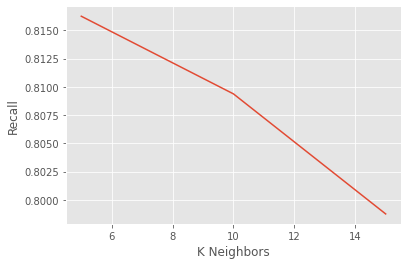

In [99]:
plt.plot(total_df["neighbors"], total_df["rec_scores"])
plt.xlabel("K Neighbors")
plt.ylabel("Recall")
plt.show()

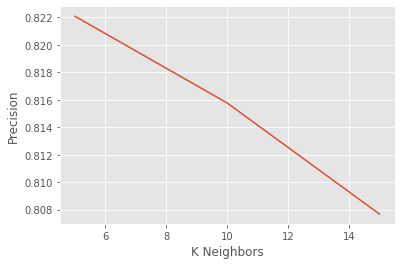

In [100]:
plt.plot(total_df["neighbors"], total_df["prec_scores"])
plt.xlabel("K Neighbors")
plt.ylabel("Precision")
plt.show()

In [102]:
knn_best = KNeighborsClassifier(n_jobs=-1)
knn_best.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

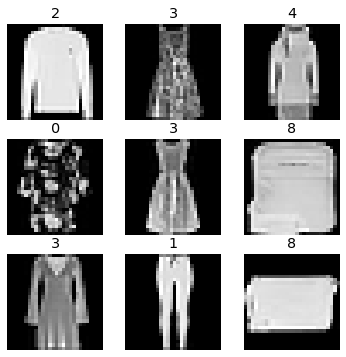

In [105]:
random_sample = np.random.choice(np.arange(len(X_test)), 9)
y_pred = knn_best.predict(X_test[random_sample])
gen.visualize_subplot(
    X_test[random_sample].reshape(-1, 28, 28),
    y_pred, (3, 3), (6, 6)
)

## **Trabajo Asíncrono**<a name="id9"></a>

- Con otro con conjunto de imágenes, construir una gráfica que muestre cómo varía el rendimiento sobre entrenamiento y validación a medida que aumenta el valor de k. A partir de esta gráfica, mostrar el rendimiento sobre el test set con el valor de k seleccionado.
- Luego, utilizar [`GridSearch`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para determinar los mejores valores de los hiperparámetros. Para eso, averiguar sobre los siguientes hiperparámetros:
    - `n_neighbors`
    - `weights`
    - `algorithm`
- Por último, mostrar algunas imágenes del conjunto test con la clase estimada por el clasificador y mostrar los resultados en una cuadrícula.